In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.optim import Adam
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#Ссылка на датасет https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification

In [4]:
# Создание и нормализация обучающей, тестовой и выборки валидации

batch_size = 512

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_path = "C:/Users/das-s/Downloads/Cards/train"
train_ds = datasets.ImageFolder(root=train_path, transform=transform)
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)

test_path = "C:/Users/das-s/Downloads/Cards/test"
test_ds = datasets.ImageFolder(root=test_path, transform=transform)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, pin_memory=True)

validation_path = "C:/Users/das-s/Downloads/Cards/valid"
validation_ds = datasets.ImageFolder(root=validation_path, transform=transform)
validation_dataloader = DataLoader(validation_ds, batch_size=batch_size, shuffle=True, pin_memory=True)

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Feature batch shape: torch.Size([512, 3, 224, 224])
Labels batch shape: torch.Size([512])


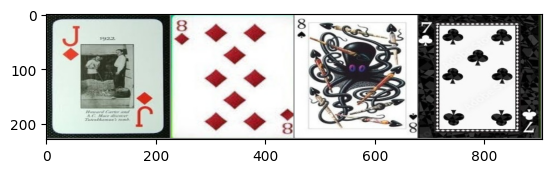

jack of diamonds	 eight of diamonds	 eight of spades	 seven of clubs	


In [6]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
images = []
for i in range(4):
    images.append(train_features[i])
imshow(torchvision.utils.make_grid(images)) # show images
print(' '.join(f'{train_ds.classes[train_labels[j]]}\t' for j in range(4))) # print labels


In [7]:
class CNN(nn.Module):
    def __init__(self, channel, num_classes):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(nn.Dropout(0.3),
                                    nn.Conv2d(channel, 16, kernel_size=3),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(nn.Dropout(0.3),
                                    nn.Conv2d(16, 32, kernel_size=3),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(nn.Dropout(0.3),
                                    nn.Conv2d(32, 64, kernel_size=3),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(nn.Dropout(0.3),
                                    nn.Conv2d(64, 128, kernel_size=3),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer5 = nn.Sequential(nn.Dropout(0.3),
                                    nn.Conv2d(128, 256, kernel_size=3),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())



        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(256*10*10, 1024),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(1024, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

In [8]:
model = CNN(3, len(test_ds.classes))
model.to(device)

CNN(
  (layer1): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Dropout(p=0.3, inp

In [9]:
for i, l in test_dataloader:
    print(model(i.to(device)).shape)
    break

torch.Size([180, 36])


In [10]:
def train(model, train_dataloader, optimizer, loss_func):
    losses = []
    model.train()
    print('Train')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for data, labels in tqdm(train_dataloader):
        counter += 1
        data = data.to(device)
        labels = labels.to(device)

        outputs = model(data)
        # calculate the loss
        loss = loss_func(outputs, labels)
        train_running_loss += loss.item()
        losses.append(loss.item())
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(train_dataloader.dataset))
    return epoch_loss, epoch_acc, losses

In [11]:
def validate(model, validation_dataloader, loss_func):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for data, labels in tqdm(validation_dataloader):
            counter += 1
            data = data.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(data)
            # calculate the loss
            loss = loss_func(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(validation_dataloader.dataset))
    return epoch_loss, epoch_acc

In [12]:
optimizer = Adam(params=model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
num_epochs = 40

In [13]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
all_t_losses = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} of {num_epochs}")
    train_epoch_loss, train_epoch_acc, all_t_epoch_losses = train(model, train_dataloader, 
                                              optimizer, loss_func)
    valid_epoch_loss, valid_epoch_acc = validate(model, validation_dataloader,  
                                                 loss_func)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    all_t_losses.append(all_t_epoch_losses)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

Epoch 1 of 40
Train


100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Training loss: 6.485, training acc: 5.024
Validation loss: 3.174, validation acc: 12.222
--------------------------------------------------
Epoch 2 of 40
Train


100%|██████████| 11/11 [00:17<00:00,  1.62s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Training loss: 3.180, training acc: 15.090
Validation loss: 2.780, validation acc: 19.444
--------------------------------------------------
Epoch 3 of 40
Train


100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Training loss: 2.777, training acc: 22.816
Validation loss: 2.523, validation acc: 27.222
--------------------------------------------------
Epoch 4 of 40
Train


100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Training loss: 2.464, training acc: 27.935
Validation loss: 2.386, validation acc: 32.222
--------------------------------------------------
Epoch 5 of 40
Train


100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Training loss: 2.274, training acc: 32.445
Validation loss: 2.319, validation acc: 35.000
--------------------------------------------------
Epoch 6 of 40
Train


100%|██████████| 11/11 [00:17<00:00,  1.59s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Training loss: 2.152, training acc: 34.881
Validation loss: 2.077, validation acc: 41.111
--------------------------------------------------
Epoch 7 of 40
Train


100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Training loss: 2.030, training acc: 38.611
Validation loss: 1.948, validation acc: 42.222
--------------------------------------------------
Epoch 8 of 40
Train


100%|██████████| 11/11 [00:17<00:00,  1.59s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


Training loss: 1.963, training acc: 40.476
Validation loss: 1.773, validation acc: 43.889
--------------------------------------------------
Epoch 9 of 40
Train


100%|██████████| 11/11 [00:17<00:00,  1.59s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Training loss: 1.878, training acc: 42.017
Validation loss: 1.732, validation acc: 51.667
--------------------------------------------------
Epoch 10 of 40
Train


100%|██████████| 11/11 [00:17<00:00,  1.59s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Training loss: 1.828, training acc: 44.282
Validation loss: 1.687, validation acc: 50.000
--------------------------------------------------
Epoch 11 of 40
Train


100%|██████████| 11/11 [00:17<00:00,  1.59s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Training loss: 1.736, training acc: 45.328
Validation loss: 1.620, validation acc: 52.222
--------------------------------------------------
Epoch 12 of 40
Train


100%|██████████| 11/11 [00:18<00:00,  1.65s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


Training loss: 1.676, training acc: 48.506
Validation loss: 1.554, validation acc: 52.778
--------------------------------------------------
Epoch 13 of 40
Train


100%|██████████| 11/11 [00:17<00:00,  1.59s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Training loss: 1.625, training acc: 48.392
Validation loss: 1.552, validation acc: 55.000
--------------------------------------------------
Epoch 14 of 40
Train


100%|██████████| 11/11 [00:20<00:00,  1.85s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


Training loss: 1.591, training acc: 49.591
Validation loss: 1.546, validation acc: 53.889
--------------------------------------------------
Epoch 15 of 40
Train


100%|██████████| 11/11 [00:20<00:00,  1.85s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Training loss: 1.542, training acc: 51.475
Validation loss: 1.447, validation acc: 56.667
--------------------------------------------------
Epoch 16 of 40
Train


100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Training loss: 1.500, training acc: 52.559
Validation loss: 1.443, validation acc: 58.333
--------------------------------------------------
Epoch 17 of 40
Train


100%|██████████| 11/11 [00:19<00:00,  1.74s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Training loss: 1.460, training acc: 53.682
Validation loss: 1.412, validation acc: 61.111
--------------------------------------------------
Epoch 18 of 40
Train


100%|██████████| 11/11 [00:18<00:00,  1.71s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Training loss: 1.416, training acc: 55.224
Validation loss: 1.427, validation acc: 56.667
--------------------------------------------------
Epoch 19 of 40
Train


100%|██████████| 11/11 [00:18<00:00,  1.72s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Training loss: 1.362, training acc: 56.422
Validation loss: 1.405, validation acc: 60.000
--------------------------------------------------
Epoch 20 of 40
Train


100%|██████████| 11/11 [00:19<00:00,  1.73s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Training loss: 1.371, training acc: 56.156
Validation loss: 1.343, validation acc: 60.556
--------------------------------------------------
Epoch 21 of 40
Train


100%|██████████| 11/11 [00:24<00:00,  2.27s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Training loss: 1.323, training acc: 59.182
Validation loss: 1.322, validation acc: 64.444
--------------------------------------------------
Epoch 22 of 40
Train


100%|██████████| 11/11 [00:21<00:00,  1.92s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Training loss: 1.247, training acc: 60.266
Validation loss: 1.284, validation acc: 64.444
--------------------------------------------------
Epoch 23 of 40
Train


100%|██████████| 11/11 [00:21<00:00,  1.91s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Training loss: 1.215, training acc: 62.131
Validation loss: 1.263, validation acc: 62.778
--------------------------------------------------
Epoch 24 of 40
Train


100%|██████████| 11/11 [00:21<00:00,  1.91s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Training loss: 1.196, training acc: 60.913
Validation loss: 1.307, validation acc: 60.000
--------------------------------------------------
Epoch 25 of 40
Train


100%|██████████| 11/11 [00:21<00:00,  1.91s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Training loss: 1.137, training acc: 62.931
Validation loss: 1.278, validation acc: 60.556
--------------------------------------------------
Epoch 26 of 40
Train


100%|██████████| 11/11 [00:21<00:00,  1.91s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Training loss: 1.138, training acc: 63.007
Validation loss: 1.211, validation acc: 64.444
--------------------------------------------------
Epoch 27 of 40
Train


100%|██████████| 11/11 [00:21<00:00,  1.97s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Training loss: 1.074, training acc: 65.480
Validation loss: 1.210, validation acc: 64.444
--------------------------------------------------
Epoch 28 of 40
Train


100%|██████████| 11/11 [00:21<00:00,  1.97s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Training loss: 1.047, training acc: 66.451
Validation loss: 1.228, validation acc: 70.000
--------------------------------------------------
Epoch 29 of 40
Train


100%|██████████| 11/11 [00:23<00:00,  2.16s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Training loss: 1.022, training acc: 67.003
Validation loss: 1.229, validation acc: 62.222
--------------------------------------------------
Epoch 30 of 40
Train


100%|██████████| 11/11 [00:25<00:00,  2.35s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Training loss: 0.976, training acc: 68.639
Validation loss: 1.179, validation acc: 66.111
--------------------------------------------------
Epoch 31 of 40
Train


100%|██████████| 11/11 [00:22<00:00,  2.05s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Training loss: 0.950, training acc: 69.020
Validation loss: 1.148, validation acc: 68.333
--------------------------------------------------
Epoch 32 of 40
Train


100%|██████████| 11/11 [00:22<00:00,  2.06s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Training loss: 0.902, training acc: 70.504
Validation loss: 1.152, validation acc: 65.000
--------------------------------------------------
Epoch 33 of 40
Train


100%|██████████| 11/11 [00:20<00:00,  1.89s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Training loss: 0.889, training acc: 71.399
Validation loss: 1.124, validation acc: 69.444
--------------------------------------------------
Epoch 34 of 40
Train


100%|██████████| 11/11 [00:20<00:00,  1.90s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Training loss: 0.853, training acc: 72.769
Validation loss: 1.073, validation acc: 69.444
--------------------------------------------------
Epoch 35 of 40
Train


100%|██████████| 11/11 [00:20<00:00,  1.89s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Training loss: 0.836, training acc: 73.092
Validation loss: 1.094, validation acc: 68.333
--------------------------------------------------
Epoch 36 of 40
Train


100%|██████████| 11/11 [00:22<00:00,  2.02s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


Training loss: 0.811, training acc: 74.348
Validation loss: 1.037, validation acc: 73.333
--------------------------------------------------
Epoch 37 of 40
Train


100%|██████████| 11/11 [00:24<00:00,  2.26s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Training loss: 0.766, training acc: 75.547
Validation loss: 1.078, validation acc: 71.111
--------------------------------------------------
Epoch 38 of 40
Train


100%|██████████| 11/11 [00:19<00:00,  1.75s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


Training loss: 0.728, training acc: 77.050
Validation loss: 1.081, validation acc: 73.333
--------------------------------------------------
Epoch 39 of 40
Train


100%|██████████| 11/11 [00:19<00:00,  1.74s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


Training loss: 0.724, training acc: 76.461
Validation loss: 1.033, validation acc: 76.111
--------------------------------------------------
Epoch 40 of 40
Train


100%|██████████| 11/11 [00:19<00:00,  1.75s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

Training loss: 0.705, training acc: 77.298
Validation loss: 1.013, validation acc: 75.556
--------------------------------------------------


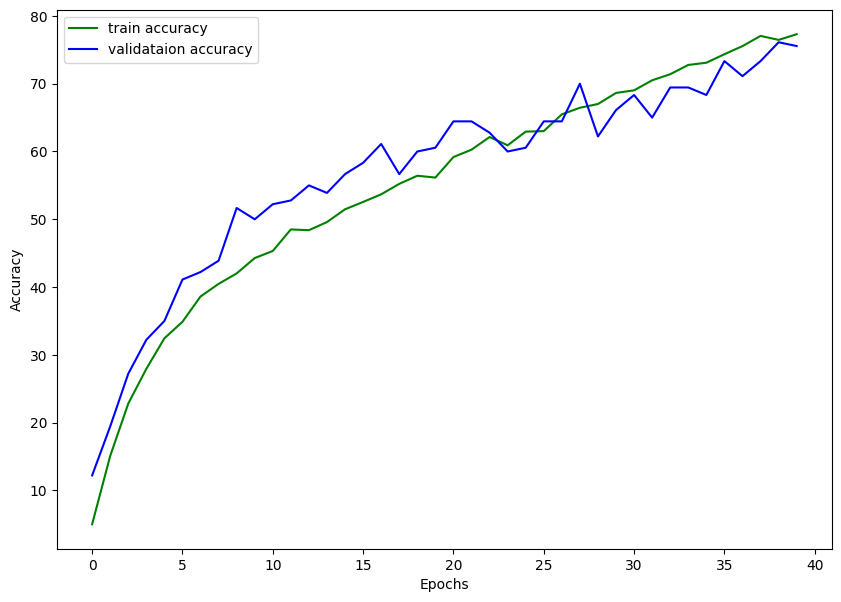

In [14]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_acc, color='green', linestyle='-', 
    label='train accuracy'
)
plt.plot(
    valid_acc, color='blue', linestyle='-', 
    label='validataion accuracy'
)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

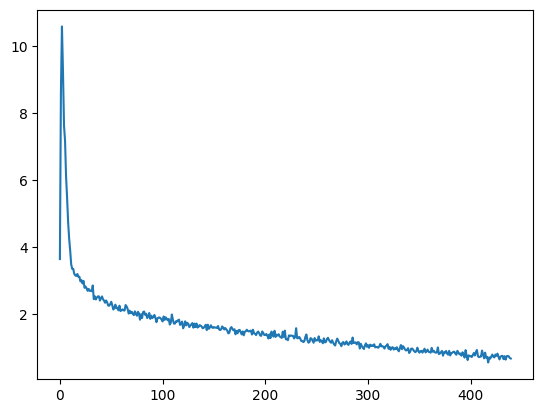

In [15]:
losses = np.array(all_t_losses)
losses =  losses.reshape(len(all_t_losses) * len(all_t_losses[0]))
plt.plot(losses)

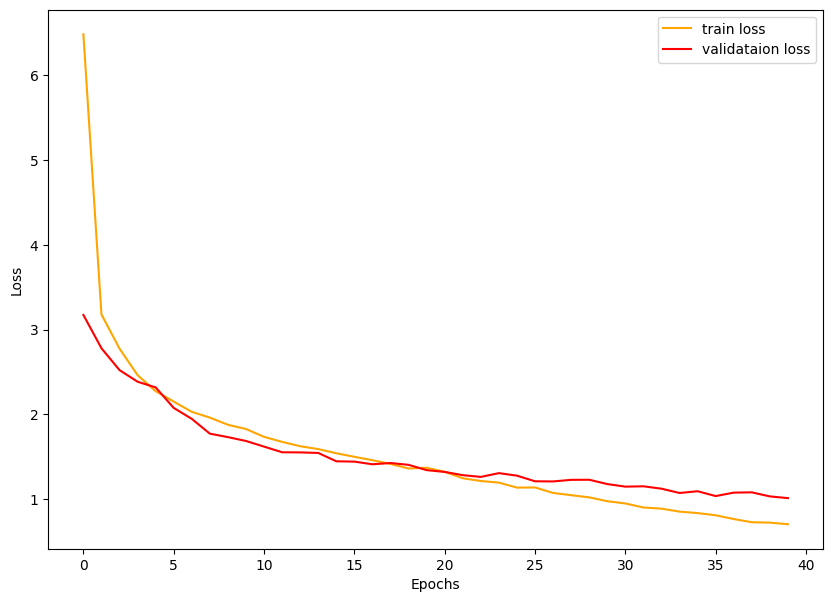

In [16]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_loss, color='orange', linestyle='-', 
    label='train loss')
plt.plot(
    valid_loss, color='red', linestyle='-', 
    label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

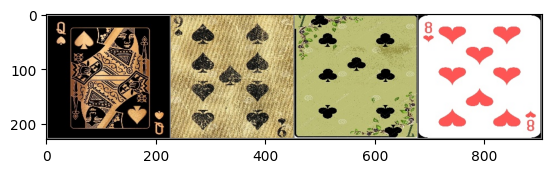

Real value:
queen of spades	 nine of spades	 seven of clubs	 eight of hearts	
Predicted value:
queen of spades	 nine of spades	 seven of spades	 eight of hearts	


In [19]:
test_fetures, test_labels = next(iter(test_dataloader))
images = []
for i in range(4):
    images.append(test_fetures[i])
imshow(torchvision.utils.make_grid(images)) # show images
print("Real value:")
print(' '.join(f'{train_ds.classes[test_labels[j]]}\t' for j in range(4))) # print labels
print("Predicted value:")
print(' '.join(f'{train_ds.classes[model(test_fetures[j].view(1, 3, 224, 224).to(device)).argmax()]}\t' for j in range(4)))

In [20]:
real_labels = []
predicted_labels = []
for data, labels in test_dataloader:
    data = data.to(device)
    output = model(data).argmax(dim=1).cpu().detach().numpy()
    for i in range(len(output)):
        predicted_labels.append(output[i])
        real_labels.append(labels[i].detach().item())

In [21]:
from sklearn.metrics import classification_report

print(classification_report(predicted_labels, real_labels, target_names=test_ds.classes))

                   precision    recall  f1-score   support

     ace of clubs       0.80      0.67      0.73         6
  ace of diamonds       0.80      0.80      0.80         5
    ace of hearts       1.00      0.56      0.71         9
    ace of spades       0.80      0.50      0.62         8
   eight of clubs       0.80      1.00      0.89         4
eight of diamonds       1.00      1.00      1.00         5
  eight of hearts       0.80      0.67      0.73         6
  eight of spades       1.00      1.00      1.00         5
    jack of clubs       0.60      1.00      0.75         3
 jack of diamonds       0.60      0.75      0.67         4
   jack of hearts       0.60      1.00      0.75         3
   jack of spades       0.60      0.60      0.60         5
    king of clubs       0.80      0.67      0.73         6
 king of diamonds       1.00      0.62      0.77         8
   king of hearts       0.80      0.80      0.80         5
   king of spades       0.40      0.67      0.50       